# Benchmark simulations on a slab mesh

The following notebook contains sample code for simulating gas exchange on an infinite sheet geometry using the model outlined in Zurita & Hurtado (2022).

First we import necessary libraries and add important directories to the system path.

In [1]:
import sys
import os
import dolfin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sys.path.append(os.getcwd()[:-6])

Following that, we import the important modules from the model source files.

In [2]:
from src.model import PerfusionGasExchangeModel
from src.params import params

Now we outline the folder name and the path to save raw data files.

In [3]:
folder = "slab_refined"
path = os.path.join("../raw-data", folder)

Now we run the solver. First, we instance the model. Then, we generate the slab mesh that mimics an infinite sheet geometry. Afterwards we prescribe the blood velocity $\mathbf{u}$ and simulate the steady transport problem _without_ hemoglobin effects. Finally, we run the actual full model using the previous solution as an initial guess for the Newton iteration, and save the boundary data.

In [4]:
model = PerfusionGasExchangeModel(folder_path=path, params=params)
model.generate_slab_mesh(
    dims=(300, 6, 6), elems=(100, 5, 5), save=True, periodic=True, refined=True
)
model.set_u(value=(400, 0, 0), save=True)
x = model.sim_sbst(hb=False, save=False)
solution = model.sim_sbst(hb=True, save=True, guess=x)
boundaries = dolfin.File(model.folder_path+'/bnd/bnd.pvd')
boundaries << model.boundaries

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.577e+07 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-08)
  Newton iteration 1: r (abs) = 4.613e-08 (tol = 1.000e-08) r (rel) = 1.289e-15 (tol = 1.000e-08)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.227e+09 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-08)
  Newton iteration 1: r (abs) = 5.223e+07 (tol = 1.000e-08) r (rel) = 4.257e-02 (tol = 1.000e-08)
  Newton iteration 2: r (abs) = 2.633e+06 (tol = 1.000e-08) r (rel) = 2.146e-03 (tol = 1.000e-08)
  Newton iteration 3: r (abs) = 5.797e+04 (tol = 1.000e-08) r (rel) = 4.724e-05 (tol = 1.000e-08)
  Newton iteration 

After simulations, we process our data in ParaView, and generate `csv` files for quick access to nodal data. We use these files to generate graphs.

In [5]:
dfpo2 = pd.read_csv("p_O2.csv")
dfpco2 = pd.read_csv("p_CO2.csv")
dfchbo2 = pd.read_csv("c_HbO2.csv")
dfchbco2 = pd.read_csv("c_HbCO2.csv")

In [6]:
dfpo2_mean = dfpo2.groupby(['Points:0'], as_index=False).mean(["p_O2"])
dfpco2_mean = dfpco2.groupby(['Points:0'], as_index=False).mean(["p_CO2"])
dfchbo2_mean = dfchbo2.groupby(['Points:0'], as_index=False).mean(["c_HbO2"])
dfchbco2_mean = dfchbco2.groupby(['Points:0'], as_index=False).mean(["c_HbCO2"])

In [7]:
def setAxLinesBW(ax):
    """
    Take each Line2D in the axes, ax, and convert the line style to be 
    suitable for black and white viewing.
    """
    MARKERSIZE = 3

    COLORMAP = {
        'b': {'marker': None, 'dash': (None,None)},
        'g': {'marker': None, 'dash': [5,5]},
        'r': {'marker': None, 'dash': [5,3,1,3]},
        'c': {'marker': None, 'dash': [1,3]},
        'm': {'marker': None, 'dash': [5,2,5,2,5,10]},
        'y': {'marker': None, 'dash': [5,3,1,2,1,10]},
        'k': {'marker': 'o', 'dash': (None,None)} #[1,2,1,10]}
        }


    lines_to_adjust = ax.get_lines()
    try:
        lines_to_adjust += ax.get_legend().get_lines()
    except AttributeError:
        pass

    for line in lines_to_adjust:
        origColor = line.get_color()
        line.set_color('black')
        line.set_dashes(COLORMAP[origColor]['dash'])
        line.set_marker(COLORMAP[origColor]['marker'])
        line.set_markersize(MARKERSIZE)

def setFigLinesBW(fig):
    """
    Take each axes in the figure, and for each line in the axes, make the
    line viewable in black and white.
    """
    for ax in fig.get_axes():
        setAxLinesBW(ax)

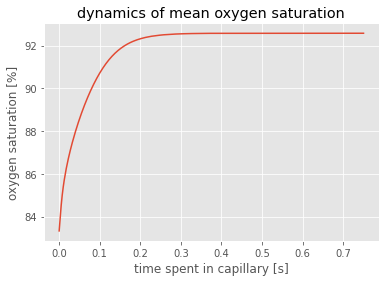

In [8]:
plt.figure()
plt.title("dynamics of mean oxygen saturation")
plt.ylabel("oxygen saturation [%]")
plt.xlabel("time spent in capillary [s]")
plt.plot(
    dfchbo2_mean["Points:0"]/400,
    100*dfchbo2_mean["c_HbO2"]/params["c_t"]
)
#plt.savefig('mean_sat.pdf')

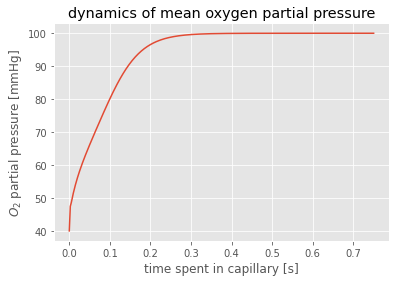

In [9]:
plt.figure()
plt.title("dynamics of mean oxygen partial pressure")
plt.ylabel(r"$O_2$ partial pressure [mmHg]")
plt.xlabel("time spent in capillary [s]")
plt.plot(
    dfpo2_mean["Points:0"]/400,
    dfpo2_mean["p_O2"]
)
#plt.savefig('mean_po2.pdf')

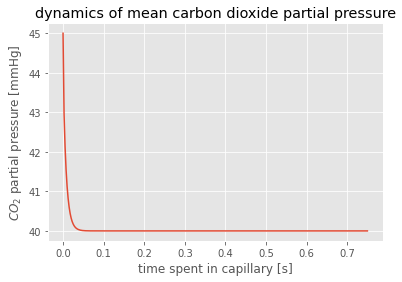

In [10]:
plt.figure()
plt.title("dynamics of mean carbon dioxide partial pressure")
plt.ylabel(r"$CO_2$ partial pressure [mmHg]")
plt.xlabel("time spent in capillary [s]")
plt.plot(
    dfpco2_mean["Points:0"]/400,
    dfpco2_mean["p_CO2"]
)
#plt.savefig('mean_pco2.pdf')

In [11]:
dfpo2_cent = pd.read_csv("p_O2_cent.csv")
dfpco2_cent = pd.read_csv("p_CO2_cent.csv")
#dfchbo2_cent = pd.read_csv("c_HbO2_cent.csv")
#dfchbco2_cent = pd.read_csv("c_HbCO2_cent.csv")
dfpo2_quar = pd.read_csv("p_O2_quar.csv")
dfpco2_quar = pd.read_csv("p_CO2_quar.csv")
#dfchbo2_quar = pd.read_csv("c_HbO2_quar.csv")
#dfchbco2_quar = pd.read_csv("c_HbCO2_quar.csv")
dfpo2_top = pd.read_csv("p_O2_top.csv")
dfpco2_top = pd.read_csv("p_CO2_top.csv")
#dfchbo2_top = pd.read_csv("c_HbO2_top.csv")
#dfchbco2_top = pd.read_csv("c_HbCO2_top.csv")

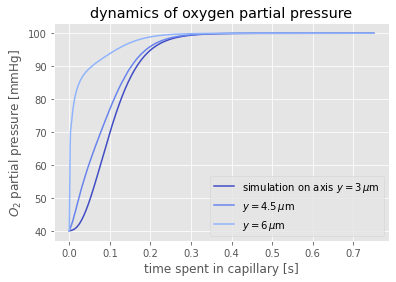

In [12]:
west_data = np.genfromtxt(
    "west_normal_data_po2_t.csv", delimiter=","
)
west_time = west_data[:, 0]
west_po2 = west_data[:, 1]

plt.figure()
plt.title("dynamics of oxygen partial pressure")
plt.ylabel(r"$O_2$ partial pressure [mmHg]")
plt.xlabel("time spent in capillary [s]")
plt.plot(
    dfpo2_cent["Points:0"]/400,
    dfpo2_cent["p_O2"], label=r"simulation on axis $y = 3 \, \mu \mathrm{m}$",
    color='#404cc4'
)
plt.plot(
    dfpo2_quar["Points:0"]/400,
    dfpo2_quar["p_O2"], label=r"$y = 4.5 \, \mu \mathrm{m}$", color='#6884ec'
)
plt.plot(
    dfpo2_top["Points:0"]/400,
    dfpo2_top["p_O2"], label=r"$y = 6 \, \mu \mathrm{m}$", color='#90b4fc'
)
#plt.plot(
#    west_time, west_po2, label=r"data from West, 2012", linestyle='--'
#)
plt.legend()
plt.savefig('po2.pdf')

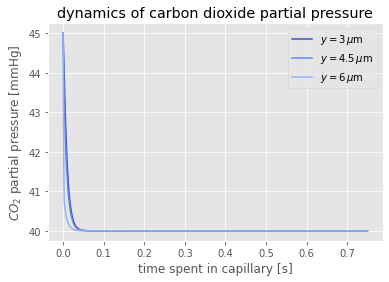

In [13]:
plt.figure()
plt.title("dynamics of carbon dioxide partial pressure")
plt.ylabel(r"$CO_2$ partial pressure [mmHg]")
plt.xlabel("time spent in capillary [s]")
plt.plot(
    dfpco2_cent["Points:0"]/400,
    dfpco2_cent["p_CO2"], label=r"$y = 3 \, \mu \mathrm{m}$",
    color='#404cc4'
)
plt.plot(
    dfpco2_quar["Points:0"]/400,
    dfpco2_quar["p_CO2"], label=r"$y = 4.5 \, \mu \mathrm{m}$", color='#6884ec'
)
plt.plot(
    dfpco2_top["Points:0"]/400,
    dfpco2_top["p_CO2"], label=r"$y = 6 \, \mu \mathrm{m}$", color='#90b4fc'
)
plt.legend()
plt.savefig('pco2.pdf')

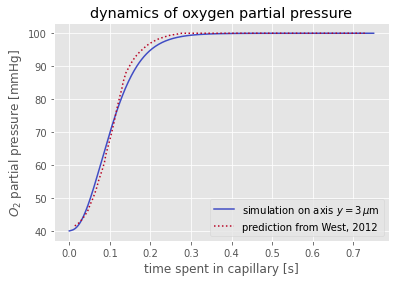

In [14]:
plt.figure()
plt.title("dynamics of oxygen partial pressure")
plt.ylabel(r"$O_2$ partial pressure [mmHg]")
plt.xlabel("time spent in capillary [s]")
plt.plot(
    dfpo2_cent["Points:0"]/400,
    dfpo2_cent["p_O2"], label=r"simulation on axis $y = 3 \, \mu \mathrm{m}$",
    color='#404cc4'
)
plt.plot(
    west_time, west_po2, label=r"prediction from West, 2012", linestyle=':',
    color='#b80424'
)
plt.legend()
plt.savefig('po2_comparison.pdf')

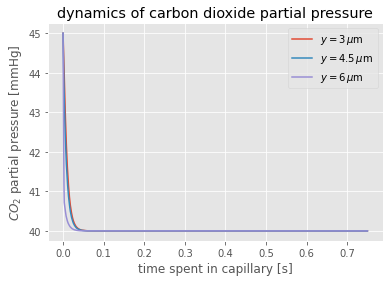

In [15]:
plt.figure()
plt.title("dynamics of carbon dioxide partial pressure")
plt.ylabel(r"$CO_2$ partial pressure [mmHg]")
plt.xlabel("time spent in capillary [s]")
plt.plot(
    dfpco2_cent["Points:0"]/400,
    dfpco2_cent["p_CO2"], label=r"$y = 3 \, \mu \mathrm{m}$"
)
plt.plot(
    dfpco2_quar["Points:0"]/400,
    dfpco2_quar["p_CO2"], label=r"$y = 4.5 \, \mu \mathrm{m}$"
)
plt.plot(
    dfpco2_top["Points:0"]/400,
    dfpco2_top["p_CO2"], label=r"$y = 6 \, \mu \mathrm{m}$"
)
plt.legend()
plt.show()